## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100.0%


Extracting fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)


In [12]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Your experiments come here:

In [13]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


In [14]:
n_epochs = 15

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, opt, loss_func)
    test_loss, test_acc = eval_epoch(model, test_loader, loss_func)

    print(f"Epoch {epoch:02d} | "
          f"Train acc: {train_acc:.4f} | "
          f"Test acc: {test_acc:.4f}")


Epoch 01 | Train acc: 0.7985 | Test acc: 0.8420
Epoch 02 | Train acc: 0.8583 | Test acc: 0.8627
Epoch 03 | Train acc: 0.8747 | Test acc: 0.8563
Epoch 04 | Train acc: 0.8849 | Test acc: 0.8667
Epoch 05 | Train acc: 0.8895 | Test acc: 0.8734
Epoch 06 | Train acc: 0.8948 | Test acc: 0.8743
Epoch 07 | Train acc: 0.9023 | Test acc: 0.8838
Epoch 08 | Train acc: 0.9048 | Test acc: 0.8796
Epoch 09 | Train acc: 0.9083 | Test acc: 0.8888
Epoch 10 | Train acc: 0.9112 | Test acc: 0.8839
Epoch 11 | Train acc: 0.9164 | Test acc: 0.8841
Epoch 12 | Train acc: 0.9178 | Test acc: 0.8855
Epoch 13 | Train acc: 0.9228 | Test acc: 0.8866
Epoch 14 | Train acc: 0.9228 | Test acc: 0.8882
Epoch 15 | Train acc: 0.9266 | Test acc: 0.8833


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [16]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
    def forward(self, x):
        return self.model(x)


In [17]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
              ReLU-5                 [-1, 2048]               0
            Linear-6                 [-1, 1024]       2,098,176
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 512]         524,800
              ReLU-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 8,432,138
Trainable params: 8,432,138
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 32.17
Estima

In [18]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

n_epochs = 40

train_loss_hist, train_acc_hist = [], []
test_loss_hist, test_acc_hist = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, opt, loss_func)
    test_loss, test_acc = eval_epoch(model, test_loader, loss_func)

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f} | "
          f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")


Epoch 01 | Train acc: 0.8004 | Test acc: 0.8258 | Train loss: 0.5358 | Test loss: 0.4574
Epoch 02 | Train acc: 0.8615 | Test acc: 0.8614 | Train loss: 0.3781 | Test loss: 0.3899
Epoch 03 | Train acc: 0.8793 | Test acc: 0.8730 | Train loss: 0.3341 | Test loss: 0.3656
Epoch 04 | Train acc: 0.8852 | Test acc: 0.8610 | Train loss: 0.3104 | Test loss: 0.3940
Epoch 05 | Train acc: 0.8928 | Test acc: 0.8853 | Train loss: 0.2915 | Test loss: 0.3335
Epoch 06 | Train acc: 0.8989 | Test acc: 0.8803 | Train loss: 0.2727 | Test loss: 0.3316
Epoch 07 | Train acc: 0.9048 | Test acc: 0.8829 | Train loss: 0.2578 | Test loss: 0.3213
Epoch 08 | Train acc: 0.9070 | Test acc: 0.8877 | Train loss: 0.2459 | Test loss: 0.3144
Epoch 09 | Train acc: 0.9110 | Test acc: 0.8825 | Train loss: 0.2364 | Test loss: 0.3514
Epoch 10 | Train acc: 0.9146 | Test acc: 0.8902 | Train loss: 0.2255 | Test loss: 0.3376
Epoch 11 | Train acc: 0.9164 | Test acc: 0.8817 | Train loss: 0.2192 | Test loss: 0.3613
Epoch 12 | Train acc:

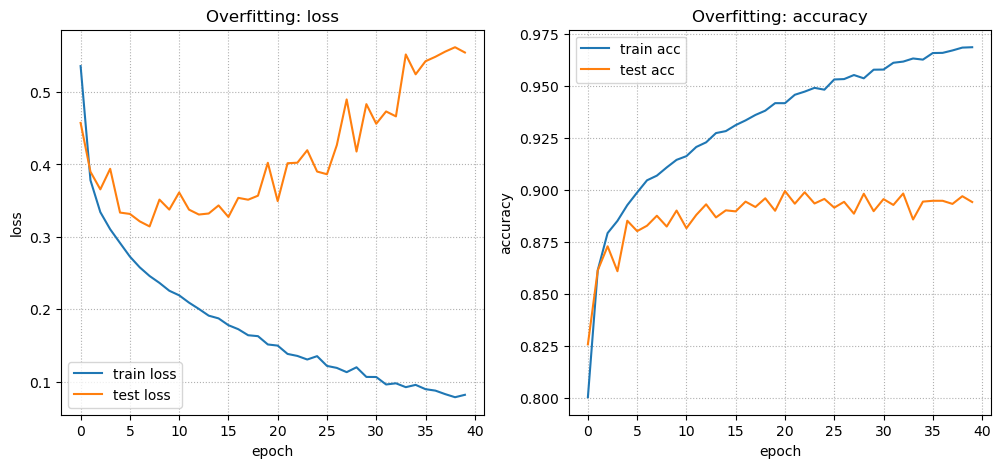

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label="train loss")
plt.plot(test_loss_hist, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Overfitting: loss")
plt.legend()
plt.grid(True, linestyle=":")

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label="train acc")
plt.plot(test_acc_hist, label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Overfitting: accuracy")
plt.legend()
plt.grid(True, linestyle=":")

plt.show()


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)


In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
       BatchNorm1d-3                 [-1, 2048]           4,096
              ReLU-4                 [-1, 2048]               0
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 2048]       4,196,352
       BatchNorm1d-7                 [-1, 2048]           4,096
              ReLU-8                 [-1, 2048]               0
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 1024]       2,098,176
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                  [

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

n_epochs = 40

train_loss_hist_fix, train_acc_hist_fix = [], []
test_loss_hist_fix, test_acc_hist_fix = [], []

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        opt.zero_grad()
        logits = model.model(x)
        loss = loss_func(logits, y)
        loss.backward()
        opt.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    train_loss = total_loss / total
    train_acc = total_correct / total

    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model.model(x)
            loss = loss_func(logits, y)

            total_loss += loss.item() * x.size(0)
            total_correct += (logits.argmax(dim=1) == y).sum().item()
            total += x.size(0)

    test_loss = total_loss / total
    test_acc = total_correct / total

    train_loss_hist_fix.append(train_loss)
    train_acc_hist_fix.append(train_acc)
    test_loss_hist_fix.append(test_loss)
    test_acc_hist_fix.append(test_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f} | "
          f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")


Epoch 01 | Train acc: 0.8258 | Test acc: 0.8459 | Train loss: 0.4838 | Test loss: 0.4205
Epoch 02 | Train acc: 0.8606 | Test acc: 0.8468 | Train loss: 0.3774 | Test loss: 0.4013
Epoch 03 | Train acc: 0.8730 | Test acc: 0.8685 | Train loss: 0.3437 | Test loss: 0.3492
Epoch 04 | Train acc: 0.8813 | Test acc: 0.8810 | Train loss: 0.3219 | Test loss: 0.3316
Epoch 05 | Train acc: 0.8872 | Test acc: 0.8780 | Train loss: 0.3056 | Test loss: 0.3375
Epoch 06 | Train acc: 0.8912 | Test acc: 0.8785 | Train loss: 0.2918 | Test loss: 0.3375
Epoch 07 | Train acc: 0.8954 | Test acc: 0.8879 | Train loss: 0.2827 | Test loss: 0.3102
Epoch 08 | Train acc: 0.8996 | Test acc: 0.8883 | Train loss: 0.2703 | Test loss: 0.3081
Epoch 09 | Train acc: 0.9014 | Test acc: 0.8827 | Train loss: 0.2617 | Test loss: 0.3209
Epoch 10 | Train acc: 0.9075 | Test acc: 0.8887 | Train loss: 0.2473 | Test loss: 0.3111
Epoch 11 | Train acc: 0.9075 | Test acc: 0.8869 | Train loss: 0.2456 | Test loss: 0.3094
Epoch 12 | Train acc:

### Conclusions:
In this work, I studied the problem of overfitting on the Fashion-MNIST dataset using fully connected neural networks.

First, I trained a relatively small FC network that achieved the required test accuracy above 0.885. This model showed stable training behaviour and reasonable generalization, confirming that even simple architectures can work well on this dataset.

Next, I intentionally increased the model capacity by using a very large fully connected network with more than 8 million parameters. This led to clear overfitting: training accuracy kept increasing up to almost 0.97, while test accuracy saturated around 0.89–0.90. The most evident sign of overfitting was the test loss, which started to increase after several epochs and reached values above 0.5 by the end of training, despite the continued improvement on the training set.

Finally, I reduced overfitting by applying regularization techniques. Adding Batch Normalization and Dropout to the overfitted model significantly stabilized training. The test loss no longer grew strongly with epochs (about 0.34 at epoch 40 instead of ~0.55), the gap between training and test accuracy became smaller, and the test accuracy improved to about 0.90–0.91. This demonstrates that regularization helps large models generalize better and makes training more robust.

Overall, this experiment shows how model complexity directly affects overfitting and how regularization techniques such as BatchNorm and Dropout can effectively mitigate it.